In [1]:
import keras 

Using TensorFlow backend.


__Data Preparation__ 

In [2]:
# function to shuffle the Dataset 
def shuffle(a, b) :
    assert len(a) == len(b) 
    shuffled_a = np.empty(a.shape, dtype = a.dtype) 
    shuffled_b = np.empty(b.shape, dtype = b.dtype) 
    permutation = np.random.permutation(len(a)) 
    for i, j in enumerate(permutation) : 
        shuffled_a[j] = a[i] 
        shuffled_b[j] = b[i] 
    return shuffled_a, shuffled_b 

In [3]:
# spliting train & test sets 
def split(X, y, split = 0.8) : 
    p = int(len(X) * split) 
    X_train = X[0:p] 
    y_train = y[0:p] 
    X_train, y_train = shuffle(X_train, y_train) 
    X_test = X[p:] 
    y_test = y[p:] 
    return X_train, X_test, y_train, y_test 

In [4]:
import pandas as pd 
import numpy as np 
data = pd.read_csv('data.csv', index_col='Date')  
data.head() 

,Open,High,Low,Close,Adj Close,Volume,Returns,Target
Date,,,,,,,,
2009-12-31,137.09,137.28,134.52,134.52,134.52,4523000,0.000000,-1
2010-01-04,136.25,136.61,133.14,133.90,133.90,7599900,-0.004620,-1
2010-01-05,133.43,135.48,131.81,134.69,134.69,8851900,0.005883,1
2010-01-06,134.60,134.73,131.65,132.25,132.25,7178800,-0.018282,-1
2010-01-07,132.01,132.32,128.80,130.00,130.00,11030200,-0.017160,-1


In [5]:
Open = data.Open.tolist() 
High = data.High.tolist()
Low = data.Low.tolist() 
Close = data['Adj Close'].tolist() 
Volume = data.Volume.tolist() 
#print(len(Open), len(High), len(High), len(Close), len(Volume)) 
Window = 30 
emb_size = 5 
step = 1 
forecast = 1 
X, y = list(), list() 

In [6]:
# we are interested in movement in price rather than exact day to day value, considering 30day window
for i in range (0, len(data), step) :
    try:
        o = Open[i : i + Window] 
        h = High[i : i + Window]
        l = Low[i : i + Window] 
        c = Close[i : i + Window] 
        v = Volume[i : i + Window] 
        # normalizing the data 
        o = (np.array(o) - np.mean(o)) / np.std(o) 
        h = (np.array(h) - np.mean(h)) / np.std(h) 
        l = (np.array(l) - np.mean(l)) / np.std(l) 
        c = (np.array(c) - np.mean(c)) / np.std(c) 
        v = (np.array(v) - np.mean(v)) / np.std(v) 
        
        x_i = Close[i : i + Window] # closing price of stock for every 30 days 
        y_i = Close[i + Window + forecast] # Closing price a day after our window 
        last_close = x_i[-1] 
        next_close = y_i 
        # target needs to have 2 diemensions for 2 layer activation 
        if (last_close < next_close) : 
            y_i = [1, 0] # upward trend with 100% probability
        else: 
            y_i = [0, 1] # downward trend with 100% probability 
            
        x_i = np.column_stack((o,h,l,c,v))
    except Exception as e: 
        break 
    X.append(x_i) 
    y.append(y_i) 

In [7]:
# creating training and testing data for modelling
X, y = np.array(X), np.array(y)  
X_train, X_test, y_train, y_test = split(X, y) 
# ensuring shape as length, window, features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], emb_size)) 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], emb_size)) 
print(X_train.shape, X_test.shape) 

(1940, 30, 5) (486, 30, 5)


In [8]:
# model building: CNN 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import * 

In [9]:
model = Sequential() 
# layer 1
model.add(Convolution1D(input_shape = (Window, emb_size), filters = 16, kernel_size = 4, padding = 'same'))
model.add(BatchNormalization()) 
model.add(LeakyReLU()) 
model.add(Dropout(0.5)) 
# layer 2
model.add(Convolution1D(filters = 8, kernel_size = 4, padding = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5)) 
model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))
opt = Nadam(lr=0.002) 
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="lolkek.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 

In [10]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 128, verbose=1, 
                    validation_data=(X_test, y_test), callbacks=[reduce_lr, checkpointer],
                    shuffle=True) 

Train on 1940 samples, validate on 486 samples
Epoch 1/100
1940/1940 [==============================] - 1s 622us/step - loss: 0.8724 - accuracy: 0.5144 - val_loss: 0.7133 - val_accuracy: 0.5144

Epoch 00001: val_loss improved from inf to 0.71328, saving model to lolkek.hdf5
Epoch 2/100
1940/1940 [==============================] - 0s 74us/step - loss: 0.8774 - accuracy: 0.5160 - val_loss: 0.7130 - val_accuracy: 0.5103

Epoch 00002: val_loss improved from 0.71328 to 0.71295, saving model to lolkek.hdf5
Epoch 3/100
1940/1940 [==============================] - 0s 83us/step - loss: 0.8637 - accuracy: 0.4876 - val_loss: 0.7119 - val_accuracy: 0.5082

Epoch 00003: val_loss improved from 0.71295 to 0.71191, saving model to lolkek.hdf5
Epoch 4/100
1940/1940 [==============================] - 0s 82us/step - loss: 0.8265 - accuracy: 0.5263 - val_loss: 0.7105 - val_accuracy: 0.5062

Epoch 00004: val_loss improved from 0.71191 to 0.71049, saving model to lolkek.hdf5
Epoch 5/100
1940/1940 [=========

1940/1940 [==============================] - 0s 71us/step - loss: 0.7080 - accuracy: 0.5227 - val_loss: 0.6987 - val_accuracy: 0.5247

Epoch 00038: val_loss did not improve from 0.69602
Epoch 39/100
1940/1940 [==============================] - 0s 68us/step - loss: 0.7145 - accuracy: 0.5222 - val_loss: 0.6985 - val_accuracy: 0.5185

Epoch 00039: val_loss did not improve from 0.69602
Epoch 40/100
1940/1940 [==============================] - 0s 66us/step - loss: 0.7090 - accuracy: 0.5216 - val_loss: 0.6989 - val_accuracy: 0.5144

Epoch 00040: val_loss did not improve from 0.69602
Epoch 41/100
1940/1940 [==============================] - 0s 70us/step - loss: 0.7178 - accuracy: 0.5284 - val_loss: 0.6985 - val_accuracy: 0.5103

Epoch 00041: val_loss did not improve from 0.69602
Epoch 42/100
1940/1940 [==============================] - 0s 68us/step - loss: 0.7012 - accuracy: 0.5314 - val_loss: 0.6988 - val_accuracy: 0.5062

Epoch 00042: val_loss did not improve from 0.69602
Epoch 43/100
1940/

1940/1940 [==============================] - 0s 70us/step - loss: 0.6964 - accuracy: 0.5428 - val_loss: 0.7013 - val_accuracy: 0.4794

Epoch 00079: val_loss did not improve from 0.69602
Epoch 80/100
1940/1940 [==============================] - 0s 70us/step - loss: 0.7013 - accuracy: 0.5206 - val_loss: 0.7017 - val_accuracy: 0.4835

Epoch 00080: val_loss did not improve from 0.69602
Epoch 81/100
1940/1940 [==============================] - 0s 68us/step - loss: 0.6979 - accuracy: 0.5402 - val_loss: 0.7014 - val_accuracy: 0.4918

Epoch 00081: val_loss did not improve from 0.69602
Epoch 82/100
1940/1940 [==============================] - 0s 69us/step - loss: 0.6898 - accuracy: 0.5397 - val_loss: 0.7013 - val_accuracy: 0.4877

Epoch 00082: val_loss did not improve from 0.69602
Epoch 83/100
1940/1940 [==============================] - 0s 68us/step - loss: 0.6949 - accuracy: 0.5438 - val_loss: 0.7012 - val_accuracy: 0.4938

Epoch 00083: val_loss did not improve from 0.69602
Epoch 84/100
1940/

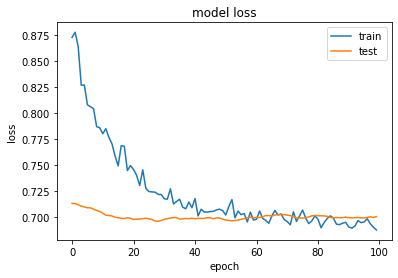

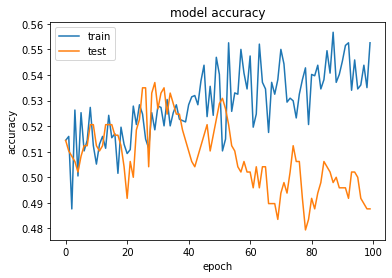

In [15]:
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best') 
plt.show() 

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(np.array(X_test))
C = confusion_matrix([np.argmax(y) for y in y_test], [np.argmax(y) for y in pred])
print(C / C.astype(np.float).sum(axis=1))
C

[[0.4519573  0.75121951]
 [0.33807829 0.53658537]]


array([[127, 154],
       [ 95, 110]], dtype=int64)

In [13]:
report = classification_report([np.argmax(i) for i in y_test], [np.argmax(i) for i in pred]) 
print(report) 

              precision    recall  f1-score   support

           0       0.57      0.45      0.50       281
           1       0.42      0.54      0.47       205

    accuracy                           0.49       486
   macro avg       0.49      0.49      0.49       486
weighted avg       0.51      0.49      0.49       486



In [14]:
# saving the predictions
cnn_prediction = pd.DataFrame(pred) 
cnn_prediction.to_csv('Deep_Learning_Prediction.csv') 